In [1]:
!pip install gym matplotlib numpy tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 111.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 193.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 240.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 191.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 223.5 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1


In [2]:
!pip install gym[classic_control]
!pip install pygame

zsh:1: no matches found: gym[classic_control]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 77.3 MB/s eta 0:00:00


In [3]:
import pygame
print(pygame.ver)


pygame 2.6.1 (SDL 2.28.4, Python 3.10.10)
Hello from the pygame community. https://www.pygame.org/contribute.html
2.6.1


First clear on episode 93
Episode 100 Average Reward: -122.92092266108793
Episode 200 Average Reward: -121.48361943259353
Episode 300 Average Reward: -118.69483595890614
Episode 400 Average Reward: -118.53942718773516
Episode 500 Average Reward: -105.3932478907689
Episode 600 Average Reward: -99.53228060040908
Episode 700 Average Reward: -103.05428561815498
Episode 800 Average Reward: -112.8265809303757
Episode 900 Average Reward: -106.03503520799481
Episode 1000 Average Reward: -108.31864521279691


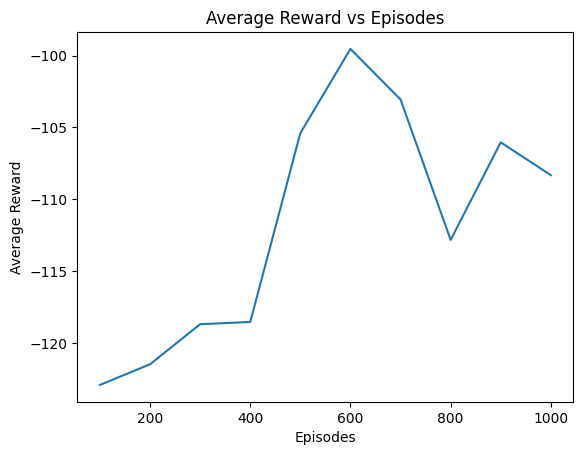

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import gym
# Initialize the environment
env = gym.make('MountainCar-v0', render_mode="rgb_array")
env.reset()

# Override boolean check
gym.utils.passive_env_checker.np = np
gym.utils.passive_env_checker.np.bool8 = bool
# Take random actions in the environment and render

frames = []
for _ in range(1000):
    frame = env.render()  # Render as an RGB array
    frames.append(frame)
    obs, reward, terminated, truncated, info = env.step(env.action_space.sample())  # Take a random action
    if terminated or truncated:
        break
env.close()

# Define a helper function to get the height of the car
def getheight(x_position):
    return np.sin(3 * x_position) * 0.45 + 0.55

# Define a custom reward function
def newreward(pos):
    if pos >= 0.5:
        return 2
    else:
        return (pos + 1.2) / 1.8 - 1

# Define the Q-learning function
def QLearning(env, learning, epsilon, min_eps, episodes):
    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low) * np.array([10, 50])
    num_states = np.round(num_states, 0).astype(int) + 1

    # Initialize Q-table
    Q = np.random.uniform(low=-1, high=0, size=(num_states[0], num_states[1], env.action_space.n))
    Qinit = np.copy(Q)

    # Initialize variables to track rewards
    reward_list = []
    ave_reward_list = []

    # Make a copy of epsilon
    eps1 = epsilon

    # Keep track of first success
    first = episodes + 1

    # Run Q-learning algorithm
    for i in range(episodes):
        # Initialize parameters
        done = False
        tot_reward, reward = 0, 0
        state, _ = env.reset()  # Unpack state and ignore additional metadata

        # Discretize state
        state_adj = (state - env.observation_space.low) * np.array([10, 50])
        state_adj = np.round(state_adj, 0).astype(int)

        while not done:
            # Render environment for last few episodes
            if i >= (episodes - 5) or i < 5:
                env.render()

            # Determine next action using epsilon-greedy strategy
            if np.random.random() < 1 - epsilon:
                action = np.argmax(Q[state_adj[0], state_adj[1]])
            else:
                action = np.random.randint(0, env.action_space.n)

            # Get next state and reward
            state2, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # Discretize state2
            state2_adj = (state2 - env.observation_space.low) * np.array([10, 50])
            state2_adj = np.round(state2_adj, 0).astype(int)

            # Save to Q-table
            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward
            else:
                delta = learning * (newreward(state2[0]) + np.max(Q[state2_adj[0], state2_adj[1]]) - Q[state_adj[0], state_adj[1], action])
                Q[state_adj[0], state_adj[1], action] += delta

            # Notify of clears
            if state2[0] >= 0.5 and i < first:
                first = i
                print(f'First clear on episode {i + 1}')

            # Update variables
            tot_reward += newreward(state2[0])
            state_adj = state2_adj

        # Decay epsilon
        if epsilon > min_eps:
            epsilon *= eps1

        # Track rewards
        reward_list.append(tot_reward)

        if (i + 1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            print(f'Episode {i + 1} Average Reward: {ave_reward}')

    env.close()
    return ave_reward_list, Q, Qinit

# Run Q-learning algorithm
env.reset()
rewards, Qopts, Qinit = QLearning(env, 0.2, 0.9, 0, 1000)

# Plot average rewards
plt.plot(100 * (np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
plt.show()


Episode 100 Average Reward: -122.9479954608451
First clear on episode 185
Episode 200 Average Reward: -119.35765090863367
Episode 300 Average Reward: -116.88684458848611
Episode 400 Average Reward: -118.24201625461272
Episode 500 Average Reward: -110.70986822514496
Episode 600 Average Reward: -111.34296215291297
Episode 700 Average Reward: -111.4044468139291
Episode 800 Average Reward: -116.11138605328499
Episode 900 Average Reward: -112.32001343382582
Episode 1000 Average Reward: -119.47008711596035


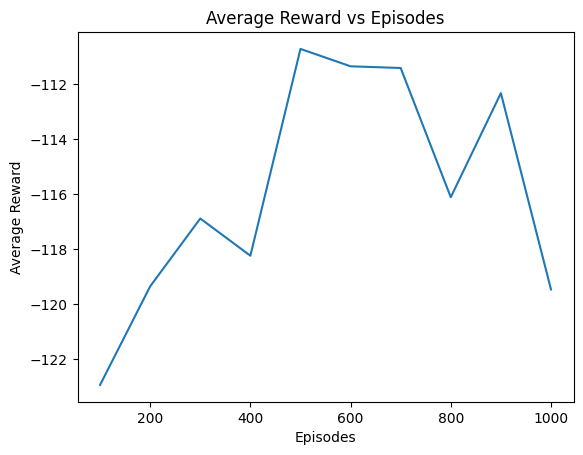

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import gym
# Override boolean check
gym.utils.passive_env_checker.np = np
gym.utils.passive_env_checker.np.bool8 = bool
# Define a helper function to get the height of the car
def getheight(x_position):
    return np.sin(3 * x_position) * 0.45 + 0.55

# Define a custom reward function
def newreward(pos):
    if pos >= 0.5:  # If the car reaches the flag
        return 2
    else:  # Otherwise, provide a scaled reward
        return (pos + 1.2) / 1.8 - 1

# Define the Q-learning function
def QLearning(env, learning, epsilon, min_eps, episodes):
    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low) * np.array([10, 50])
    num_states = np.round(num_states, 0).astype(int) + 1

    # Initialize Q-table
    Q = np.random.uniform(low=-1, high=0, size=(num_states[0], num_states[1], env.action_space.n))
    Qinit = np.copy(Q)

    # Initialize variables to track rewards
    reward_list = []
    ave_reward_list = []

    # Make a copy of epsilon
    eps1 = epsilon

    # Keep track of first success
    first = episodes + 1

    # Run Q-learning algorithm
    for i in range(episodes):
        # Initialize parameters
        done = False
        tot_reward, reward = 0, 0
        state, _ = env.reset()  # Unpack state and ignore additional metadata

        # Discretize state
        state_adj = (state - env.observation_space.low) * np.array([10, 50])
        state_adj = np.round(state_adj, 0).astype(int)

        while not done:
            # Render environment for last few episodes
            if i >= (episodes - 5) or i < 5:
                env.render()

            # Determine next action using epsilon-greedy strategy
            if np.random.random() < 1 - epsilon:
                action = np.argmax(Q[state_adj[0], state_adj[1]])
            else:
                action = np.random.randint(0, env.action_space.n)

            # Get next state and reward
            state2, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Discretize state2
            state2_adj = (state2 - env.observation_space.low) * np.array([10, 50])
            state2_adj = np.round(state2_adj, 0).astype(int)

            # Update Q-table
            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward
            else:
                delta = learning * (newreward(state2[0]) + np.max(Q[state2_adj[0], state2_adj[1]]) - Q[state_adj[0], state_adj[1], action])
                Q[state_adj[0], state_adj[1], action] += delta

            # Notify of clears
            if state2[0] >= 0.5 and i < first:
                first = i
                print(f'First clear on episode {i + 1}')

            # Update variables
            tot_reward += newreward(state2[0])
            state_adj = state2_adj

        # Decay epsilon
        if epsilon > min_eps:
            epsilon *= eps1

        # Track rewards
        reward_list.append(tot_reward)

        if (i + 1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            print(f'Episode {i + 1} Average Reward: {ave_reward}')

    env.close()
    return ave_reward_list, Q, Qinit

# Initialize the environment
env = gym.make('MountainCar-v0', render_mode="rgb_array")

# Run Q-learning algorithm
rewards, Qopts, Qinit = QLearning(env, learning=0.2, epsilon=0.9, min_eps=0.01, episodes=1000)

# Plot average rewards
plt.plot(100 * (np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
plt.show()

# Visualize the learned policy
state, _ = env.reset()
state_adj = (state - env.observation_space.low) * np.array([10, 50])
state_adj = np.round(state_adj, 0).astype(int)

done = False
while not done:
    env.render()
    action = np.argmax(Qopts[state_adj[0], state_adj[1]])
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    state_adj = (state - env.observation_space.low) * np.array([10, 50])
    state_adj = np.round(state_adj, 0).astype(int)

env.close()

In [ ]:
print("hello")

hello


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import gym
# Override boolean check
gym.utils.passive_env_checker.np = np
gym.utils.passive_env_checker.np.bool8 = bool
pos_space = np.linspace(-1.2, 0.6, 12)
vel_space = np.linspace(-0.07, 0.07, 20)

def get_state(observation):
    pos, vel = observation
    pos_bin = int(np.digitize(pos, pos_space))
    vel_bin = int(np.digitize(vel, vel_space))

    return (pos_bin, vel_bin)

def max_action(Q, state, actions=[0, 1, 2]):
    values = np.array([Q[state, a] for a in actions])
    action = np.argmax(values)

    return action

if __name__ == '__main__':
    env = gym.make('MountainCar-v0')
    env._max_episode_steps = 1000
    n_games = 50000
    alpha = 0.5
    gamma = 0.99
    eps = 1.0
    eps_decay = 0.995  # Decay epsilon by multiplying each episode
    eps_min = 0.01  # Minimum epsilon value
    eps = max(eps * eps_decay, eps_min)

    action_space = [0, 1, 2]

    states = []
    for pos in range(21):
        for vel in range(21):
            states.append((pos, vel))

    Q = {}
    for state in states:
        for action in action_space:
            Q[state, action] = 0

    score = 0
    total_rewards = np.zeros(n_games)
    for i in range(n_games):
        done = False
        obs_reset = env.reset()

        # Extract the observation from the reset output
        if isinstance(obs_reset, tuple):
            obs = obs_reset[0]  # Take the first element (observation array)
        else:
            obs = obs_reset['observation']  # Newer gym version

        #print("Observation after reset:", obs)  # Debug print

        state = get_state(obs)  # Use only the extracted observation
        if i % 100 == 0 and i > 0:
            print('episode ', i, 'score ', score, 'epsilon %.3f' % eps)
        score = 0
        while not done:
            action = np.random.choice([0, 1, 2]) if np.random.random() < eps \
                else max_action(Q, state)
            obs_step = env.step(action)

            # Debugging step to inspect `obs_step`
            #print("Step output:", obs_step)

            # Extract observation from step output
            if isinstance(obs_step, tuple):
                # Handle simplified output (older gym or variants)
                obs_ = obs_step[0]
                reward = obs_step[1]
                done = obs_step[2] if len(obs_step) > 2 else False
            else:
                # Newer gym versions (dictionary output)
                obs_ = obs_step['observation']
                reward = obs_step['reward']
                done = obs_step.get('terminated', obs_step.get('done', False))
                info = obs_step.get('info', {})  # Optional info

            #print("Observation after step:", obs_)  # Debug print

            state_ = get_state(obs_)  # Use only the extracted observation
            score += reward
            action_ = max_action(Q, state_)
            Q[state, action] = Q[state, action] + \
                alpha * (reward + gamma * Q[state_, action_] - Q[state, action])
            state = state_
        total_rewards[i] = score
        eps = eps - 2 / n_games if eps > 0.01 else 0.01


mean_rewards = np.zeros(n_games)
for t in range(n_games):
    mean_rewards[t] = np.mean(total_rewards[max(0, t-50):(t+1)])
plt.plot(mean_rewards)
plt.savefig('mountaincar.png')

    # Save the Q-table
    # with open("mountaincar.pkl", "wb") as f:
    #     pickle.dump(Q, f)


episode  100 score  -42052.0 epsilon 0.991
episode  200 score  -11708.0 epsilon 0.987
episode  300 score  -73035.0 epsilon 0.983
episode  400 score  -40723.0 epsilon 0.979
episode  500 score  -37160.0 epsilon 0.975
episode  600 score  -9295.0 epsilon 0.971
episode  700 score  -76326.0 epsilon 0.967
episode  800 score  -60377.0 epsilon 0.963
episode  900 score  -51576.0 epsilon 0.959


In [ ]:
print("hello")

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2024-11-29 10:23:51.908556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732875831.932098    1010 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732875831.938779    1010 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 10:23:51.961702: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0


2024-11-29 10:23:53.915614: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10377481658036219369
xla_global_id: -1
]


In [ ]:
!lspci | grep -i nvidia
!nvidia-smi


/usr/bin/sh: 1: lspci: not found
/usr/bin/sh: 1: nvidia-smi: not found
